In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm

In [ ]:
# This cell initializes a new model with ImageNet weights. Run the next cell for the trained one
model = models.vgg16_bn(pretrained=True)
n_classes = 6
n_inputs = model.classifier[-1].in_features
model.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.15),
                                    nn.Linear(256, n_classes),
                                    nn.Sigmoid())

In [2]:
# Load the model trained with this notebook
from kaishi.core.image.nn import Model
model = Model().model

In [3]:
# Edit the pipeline to just do fast ops
from kaishi.image import Dataset
imdata = Dataset('/home/mwharton/Data/kaishi_image_train_dataset')
imdata.pipeline.methods = [imdata.filter_invalid_file_extensions, imdata.filter_invalid_image_headers, imdata.filter_duplicates, imdata.collapse_children]
imdata.pipeline.args = [[], [], [], []]
imdata.run_pipeline()

In [ ]:
model = model.to('cuda')
steps_per_epoch = 40
data_generator = imdata.train_generator(batch_size=16)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1e-4)
n_epochs = 30

In [4]:
X_val, y_val = imdata.generate_validation_data()

In [ ]:
minval = 9999

In [ ]:
for epoch in range(n_epochs):
    print('Epoch %3d/%3d' % (epoch + 1, n_epochs))
    running_loss = 0
    lossct = 0
    for step in tqdm(range(steps_per_epoch)):
        optimizer.zero_grad()
        for X, y in data_generator:
            break
        pred = model(torch.from_numpy(X).to(torch.float32).to('cuda'))
        loss = criterion(pred, torch.from_numpy(y).to(torch.float32).to('cuda'))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        lossct += 1
    print('Loss for this epoch: ' + repr(running_loss / float(lossct)))
    val_loss = 0
    for i in range(10):
        Xtmp = X_val[i*32:(i+1)*32]
        ytmp = y_val[i*32:(i+1)*32]
        val_pred = model(torch.from_numpy(Xtmp).to(torch.float32).to('cuda'))
        val_loss += criterion(val_pred, torch.from_numpy(ytmp).to(torch.float32).to('cuda')).item()
    print('Validation loss: ' + repr(val_loss / 10.0))
    if val_loss < minval:
        minval = val_loss
        print('Improved.')
        torch.save(model.state_dict(), 'best_val.pth')

In [ ]:
model.load_state_dict(torch.load('best_val.pth'))

In [9]:
import matplotlib.pyplot as plt

In [7]:
pred = model(torch.from_numpy(X_val[:32]).to(torch.float32)).detach().numpy()  # CPU
#pred = model(torch.from_numpy(X_val[:10]).to(torch.float32).to('cuda')).cpu().detach().numpy() # GPU

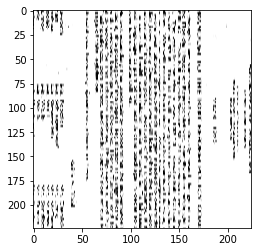

Truth: array([1., 0., 1., 0., 0., 1.])
Pred:  array([0.99921834, 0.01011626, 0.8035588 , 0.03592599, 0.0455061 ,
       0.99637115], dtype=float32)


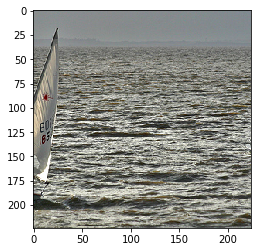

Truth: array([0., 1., 0., 0., 0., 0.])
Pred:  array([0.01193524, 0.9497579 , 0.00638713, 0.01218813, 0.01174316,
       0.28091767], dtype=float32)


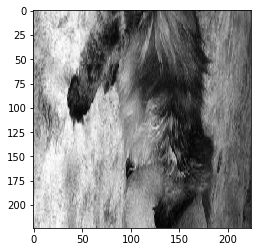

Truth: array([0., 0., 1., 0., 0., 1.])
Pred:  array([0.05856704, 0.21784237, 0.46008953, 0.4123918 , 0.15753953,
       0.98190695], dtype=float32)


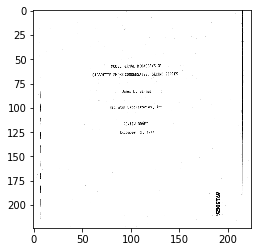

Truth: array([1., 1., 0., 0., 0., 0.])
Pred:  array([9.9943715e-01, 9.8713142e-01, 1.5930110e-03, 1.1278588e-03,
       8.4969692e-04, 6.7123154e-05], dtype=float32)


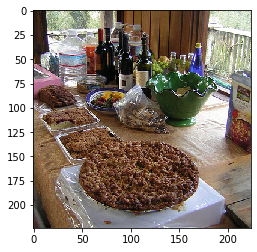

Truth: array([0., 1., 0., 0., 0., 0.])
Pred:  array([4.3914029e-06, 9.9919730e-01, 1.7517625e-04, 1.8163843e-04,
       5.9860236e-06, 2.5723295e-06], dtype=float32)


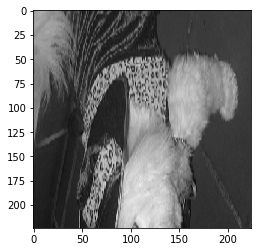

Truth: array([0., 0., 0., 1., 0., 1.])
Pred:  array([0.01591975, 0.16992825, 0.6837884 , 0.06102111, 0.07553393,
       0.9968549 ], dtype=float32)


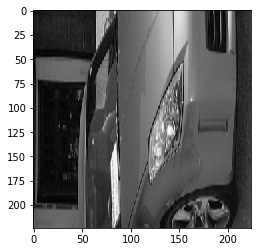

Truth: array([0., 0., 0., 1., 0., 1.])
Pred:  array([2.4670520e-04, 1.2425927e-01, 4.9450900e-03, 8.2829362e-01,
       7.8404881e-03, 9.9848109e-01], dtype=float32)


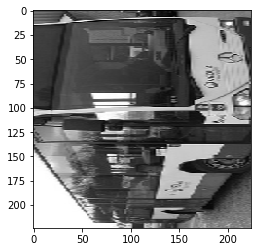

Truth: array([0., 0., 0., 1., 0., 1.])
Pred:  array([1.1824216e-07, 5.0702754e-05, 1.8141879e-04, 9.9947745e-01,
       1.9008696e-05, 9.9999940e-01], dtype=float32)


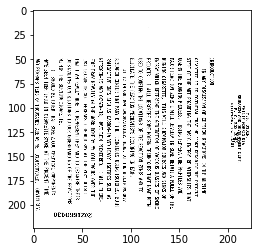

Truth: array([1., 0., 1., 0., 0., 0.])
Pred:  array([9.994574e-01, 2.665311e-03, 9.997887e-01, 1.388588e-04,
       2.483442e-04, 1.183205e-06], dtype=float32)


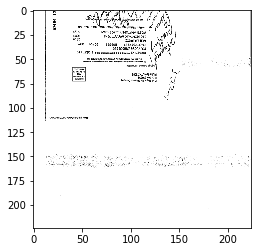

Truth: array([1., 0., 0., 0., 1., 0.])
Pred:  array([9.9996459e-01, 1.0828339e-03, 7.0658093e-04, 5.3440069e-04,
       9.8137581e-01, 1.2286633e-04], dtype=float32)


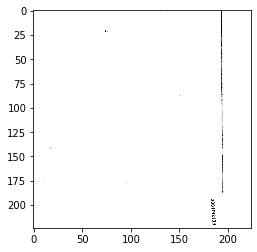

Truth: array([1., 1., 0., 0., 0., 0.])
Pred:  array([9.9758875e-01, 9.6011978e-01, 7.7307341e-03, 2.3809988e-03,
       7.3634647e-04, 5.9319202e-05], dtype=float32)


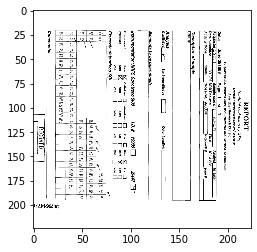

Truth: array([1., 0., 1., 0., 0., 0.])
Pred:  array([9.9999845e-01, 7.0064702e-06, 9.9994516e-01, 1.1323033e-06,
       2.6627591e-05, 3.2615965e-11], dtype=float32)


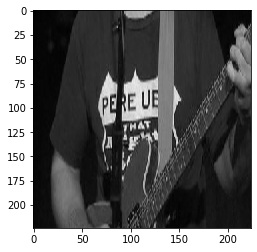

Truth: array([0., 1., 0., 0., 0., 1.])
Pred:  array([0.01471748, 0.6187256 , 0.16968493, 0.22575729, 0.03377992,
       0.9968837 ], dtype=float32)


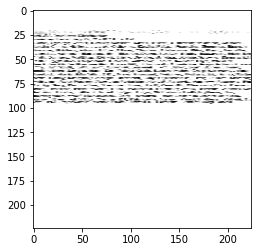

Truth: array([1., 1., 0., 0., 0., 1.])
Pred:  array([0.9934731 , 0.8023787 , 0.07654541, 0.05351355, 0.19144464,
       0.97820836], dtype=float32)


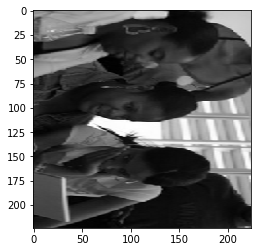

Truth: array([0., 0., 1., 0., 0., 1.])
Pred:  array([0.01024298, 0.00789673, 0.8543883 , 0.02948135, 0.01536969,
       0.998868  ], dtype=float32)


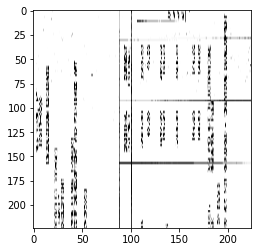

Truth: array([1., 0., 0., 1., 0., 1.])
Pred:  array([0.98870915, 0.02838325, 0.06480879, 0.8262749 , 0.04203137,
       0.9778943 ], dtype=float32)


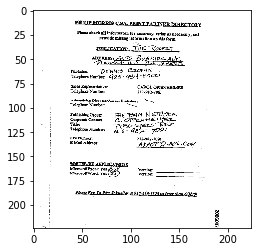

Truth: array([1., 1., 0., 0., 0., 0.])
Pred:  array([1.0000000e+00, 1.0000000e+00, 8.5991712e-09, 1.3246687e-07,
       1.0810947e-08, 5.7790409e-12], dtype=float32)


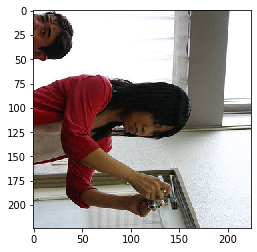

Truth: array([0., 0., 1., 0., 0., 0.])
Pred:  array([5.6174799e-04, 1.2999770e-02, 9.7462434e-01, 1.4061186e-02,
       4.9199513e-03, 2.2344729e-03], dtype=float32)


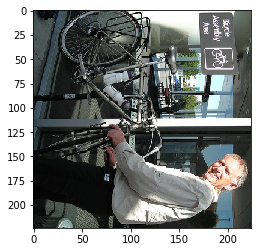

Truth: array([0., 0., 1., 0., 0., 0.])
Pred:  array([1.9326358e-06, 9.1608010e-05, 9.9962044e-01, 5.0801214e-06,
       8.2526083e-07, 1.1197702e-06], dtype=float32)


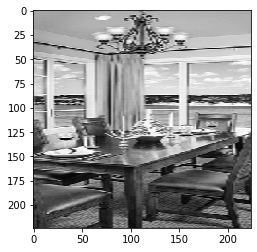

Truth: array([0., 1., 0., 0., 0., 1.])
Pred:  array([8.8302942e-04, 9.3517554e-01, 1.9131225e-02, 2.2837695e-02,
       7.2936025e-03, 9.9967575e-01], dtype=float32)


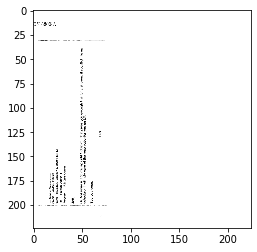

Truth: array([1., 0., 0., 1., 0., 0.])
Pred:  array([9.9952698e-01, 3.0981724e-03, 1.3231925e-03, 9.8841619e-01,
       2.4274730e-03, 1.0492018e-04], dtype=float32)


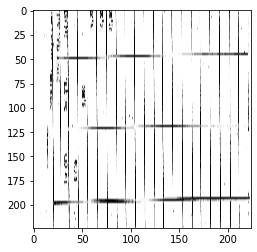

Truth: array([1., 0., 0., 1., 0., 1.])
Pred:  array([0.9942093 , 0.03589814, 0.09901518, 0.84672105, 0.02748039,
       0.98316723], dtype=float32)


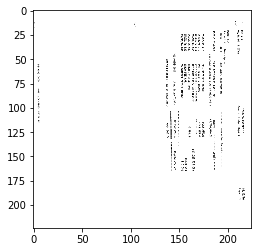

Truth: array([1., 0., 1., 0., 0., 0.])
Pred:  array([9.9929333e-01, 7.3883258e-04, 9.9663204e-01, 1.0029026e-03,
       4.1498017e-04, 7.1429495e-06], dtype=float32)


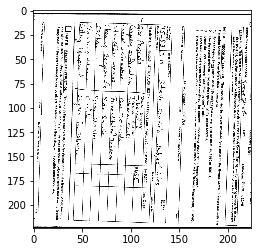

Truth: array([1., 0., 1., 0., 0., 0.])
Pred:  array([9.9351221e-01, 1.4740120e-02, 8.9146668e-01, 4.2622365e-02,
       1.5555056e-02, 7.6528864e-05], dtype=float32)


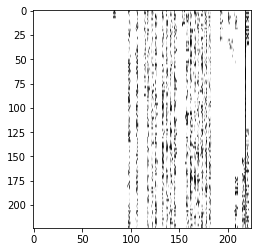

Truth: array([1., 0., 1., 0., 0., 1.])
Pred:  array([0.9998337 , 0.00209703, 0.96218735, 0.04358189, 0.00577251,
       0.9995776 ], dtype=float32)


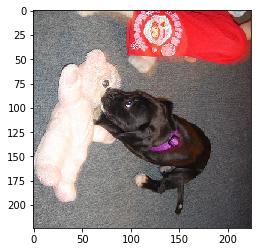

Truth: array([0., 0., 1., 0., 0., 0.])
Pred:  array([5.8566839e-03, 1.1189778e-01, 8.6950302e-01, 4.0423586e-03,
       5.2812915e-02, 4.7841288e-05], dtype=float32)


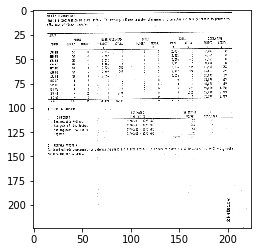

Truth: array([1., 1., 0., 0., 0., 0.])
Pred:  array([9.9999642e-01, 9.9980181e-01, 1.7268339e-05, 1.9888788e-05,
       3.5223722e-05, 2.0562372e-07], dtype=float32)


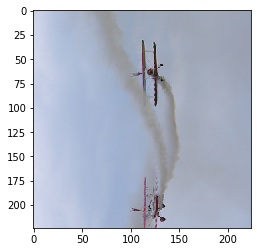

Truth: array([0., 0., 0., 1., 0., 0.])
Pred:  array([0.00173964, 0.06995506, 0.64105594, 0.28467232, 0.0204624 ,
       0.3025904 ], dtype=float32)


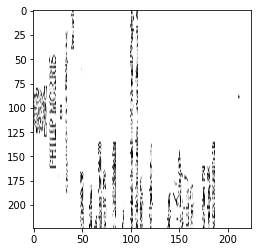

Truth: array([1., 0., 0., 1., 0., 1.])
Pred:  array([9.9969745e-01, 9.7409583e-04, 1.3066131e-03, 9.9784350e-01,
       3.0292632e-04, 9.9919027e-01], dtype=float32)


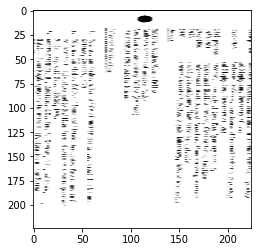

Truth: array([1., 0., 1., 0., 0., 1.])
Pred:  array([1.0000000e+00, 1.8475619e-07, 9.9990547e-01, 3.1379116e-07,
       8.3042469e-06, 9.9999642e-01], dtype=float32)


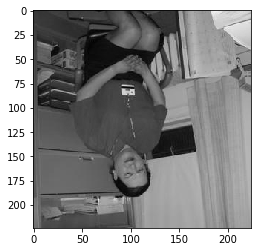

Truth: array([0., 0., 0., 0., 1., 0.])
Pred:  array([2.1204380e-04, 5.3710432e-04, 1.9032329e-04, 1.2715744e-04,
       9.9535406e-01, 1.6578347e-04], dtype=float32)


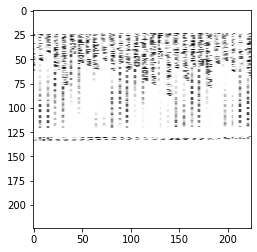

Truth: array([1., 0., 1., 0., 0., 1.])
Pred:  array([9.9999952e-01, 9.5217234e-05, 9.9886334e-01, 4.0931060e-05,
       9.1783855e-05, 9.9951732e-01], dtype=float32)


In [10]:
for i in range(32):
    plt.imshow(np.swapaxes(X_val[i], 0, 2))
    plt.show()
    print('Truth: ' + repr(y_val[i]))
    print('Pred:  ' + repr(pred[i]))

# CLASS LABELS: [DOCUMENT, RECTIFIED, ROTATED_RIGHT, ROTATED_LEFT, UPSIDE_DOWN, STRETCHING]